# TNT Loop-Bridge: SAOS

## Objectives

- Fit TNT Loop-Bridge model to Small Amplitude Oscillatory Shear (SAOS) data
- Understand linear viscoelastic response with constant bridge fraction
- Analyze effective Maxwell behavior at equilibrium
- Quantify storage and loss moduli from loop-bridge kinetics
- Perform Bayesian inference for parameter uncertainty

## Setup

In [1]:
import os
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTLoopBridge

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_ml_ikh_flow_curve,
    load_pnas_startup,
    load_laponite_relaxation,
    load_ml_ikh_creep,
    load_epstein_saos,
    load_pnas_laos,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_loop_bridge_param_names,
    plot_loop_bridge_fraction,
    plot_bell_nu_sweep,
    compute_maxwell_moduli,
    compute_bell_effective_lifetime,
    print_nu_interpretation,
)

param_names = get_tnt_loop_bridge_param_names()

## Theory: SAOS Response

### Physical Picture

In Small Amplitude Oscillatory Shear (SAOS):
- Strain amplitude is small (typically < 1%)
- Linear response regime
- Bridge fraction remains constant at equilibrium: f_B = f_B_eq
- No force-enhanced detachment (shear rate oscillates around zero)

### Governing Equations

**Effective Maxwell Model:**

At equilibrium (f_B = f_B_eq), the model reduces to a Maxwell element:
```
G_eff = f_B_eq * G
tau_eff = tau_b
```

**Storage Modulus (elastic):**
```
G'(ω) = G_eff * (ω * tau_b)² / [1 + (ω * tau_b)²]
```

**Loss Modulus (viscous):**
```
G''(ω) = G_eff * (ω * tau_b) / [1 + (ω * tau_b)²] + η_s * ω
```

**Complex Modulus:**
```
G*(ω) = G'(ω) + i * G''(ω)
|G*| = sqrt(G'² + G''²)
```

### Frequency Regimes

1. **Low frequency (ω << 1/tau_b):**
   - G' ~ G_eff * (ω * tau_b)² (elastic, terminal regime)
   - G'' ~ G_eff * (ω * tau_b) + η_s * ω (viscous dominant)
   - G'' > G' (liquid-like)

2. **Crossover (ω ~ 1/tau_b):**
   - G' = G'' (loss tangent = 1)
   - Defines characteristic relaxation frequency

3. **High frequency (ω >> 1/tau_b):**
   - G' ~ G_eff (elastic plateau)
   - G'' ~ η_s * ω (solvent viscosity)
   - G' > G'' (solid-like)

### Key Features

- **Plateau modulus**: G_eff = f_B_eq * G
- **Crossover frequency**: ω_c = 1 / tau_b
- **Solvent contribution**: G'' increases linearly at high ω
- **Bridge fraction**: Determines plateau height (higher f_B_eq → higher G_eff)

## Load SAOS Data

Data points: 19
Frequency range: 1.01e-01 - 9.94e+01 rad/s
G' range: 8.28e+00 - 2.93e+03 Pa
G'' range: 2.78e+01 - 2.22e+03 Pa


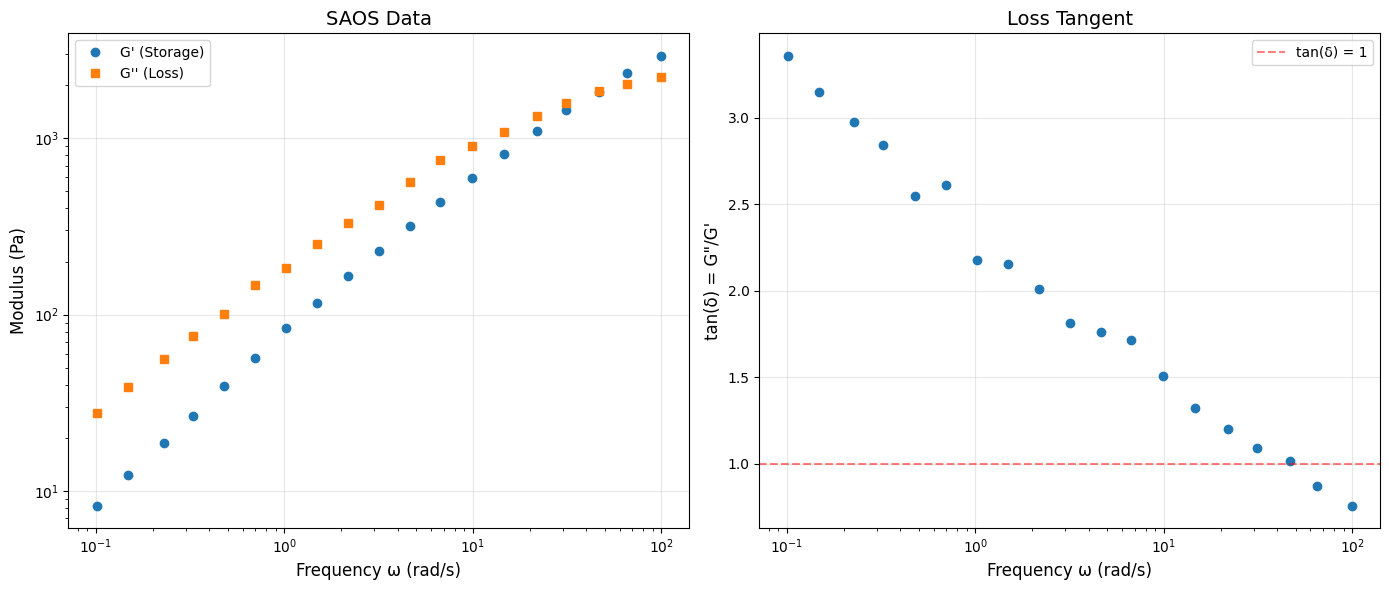

In [2]:
omega, G_prime, G_double_prime = load_epstein_saos()

# Compute complex modulus magnitude
G_star_mag = np.sqrt(G_prime**2 + G_double_prime**2)

print(f"Data points: {len(omega)}")
print(f"Frequency range: {omega.min():.2e} - {omega.max():.2e} rad/s")
print(f"G' range: {G_prime.min():.2e} - {G_prime.max():.2e} Pa")
print(f"G'' range: {G_double_prime.min():.2e} - {G_double_prime.max():.2e} Pa")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# G' and G'' vs omega
ax1.loglog(omega, G_prime, 'o', label="G' (Storage)", markersize=6)
ax1.loglog(omega, G_double_prime, 's', label="G'' (Loss)", markersize=6)
ax1.set_xlabel('Frequency ω (rad/s)', fontsize=12)
ax1.set_ylabel('Modulus (Pa)', fontsize=12)
ax1.set_title('SAOS Data', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Loss tangent
tan_delta = G_double_prime / G_prime
ax2.semilogx(omega, tan_delta, 'o', markersize=6)
ax2.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='tan(δ) = 1')
ax2.set_xlabel('Frequency ω (rad/s)', fontsize=12)
ax2.set_ylabel('tan(δ) = G\"/G\'', fontsize=12)
ax2.set_title('Loss Tangent', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## NLSQ Fitting

In [3]:
model = TNTLoopBridge()

print("Starting NLSQ fit...")
t_start = time.time()

nlsq_result = model.fit(omega, G_star_mag, test_mode='oscillation', method='scipy')

t_nlsq = time.time() - t_start
print(f"\nNLSQ fit completed in {t_nlsq:.2f} seconds")
print(f"\nFitted parameters:")
for name in param_names:
    value = model.parameters.get_value(name)
    print(f"  {name}: {value:.4e}")

G_star_mag_pred_fit = model.predict(omega, test_mode='oscillation')
metrics = compute_fit_quality(G_star_mag, G_star_mag_pred_fit)
print(f"\nFit quality:")
print(f"  R²: {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4e}")
# print(f"  Max relative error: {metrics['max_rel_error']:.2f}%")

Starting NLSQ fit...



NLSQ fit completed in 0.39 seconds

Fitted parameters:
  G: 1.5635e+03
  tau_b: 2.0359e-01
  tau_a: 2.7156e+01
  nu: 7.2104e+00
  f_B_eq: 5.4901e-01
  eta_s: 4.4225e+01

Fit quality:
  R²: 0.950999
  RMSE: 2.4478e+02


## NLSQ Fit Visualization

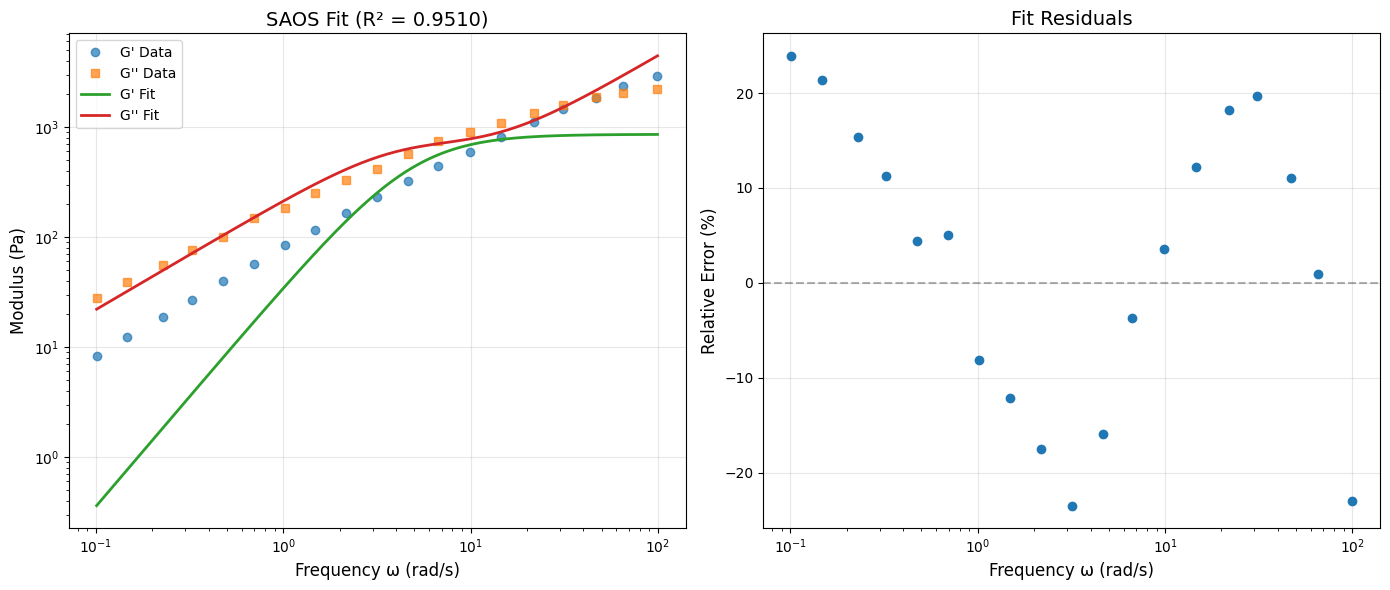

In [4]:
omega_pred = jnp.logspace(jnp.log10(omega.min()), jnp.log10(omega.max()), 200)
G_prime_pred, G_double_prime_pred = model.predict_saos(omega_pred)
G_star_pred = jnp.sqrt(G_prime_pred**2 + G_double_prime_pred**2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Moduli fit
ax1.loglog(omega, G_prime, 'o', label="G' Data", markersize=6, alpha=0.7)
ax1.loglog(omega, G_double_prime, 's', label="G'' Data", markersize=6, alpha=0.7)
ax1.loglog(omega_pred, G_prime_pred, '-', label="G' Fit", linewidth=2)
ax1.loglog(omega_pred, G_double_prime_pred, '-', label="G'' Fit", linewidth=2)
ax1.set_xlabel('Frequency ω (rad/s)', fontsize=12)
ax1.set_ylabel('Modulus (Pa)', fontsize=12)
ax1.set_title(f'SAOS Fit (R² = {metrics["R2"]:.4f})', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Residuals
G_star_fit = model.predict(omega, test_mode='oscillation')
residuals = (G_star_mag - G_star_fit) / G_star_mag * 100
ax2.semilogx(omega, residuals, 'o', markersize=6)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Frequency ω (rad/s)', fontsize=12)
ax2.set_ylabel('Relative Error (%)', fontsize=12)
ax2.set_title('Fit Residuals', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## Physical Analysis: Effective Maxwell Parameters

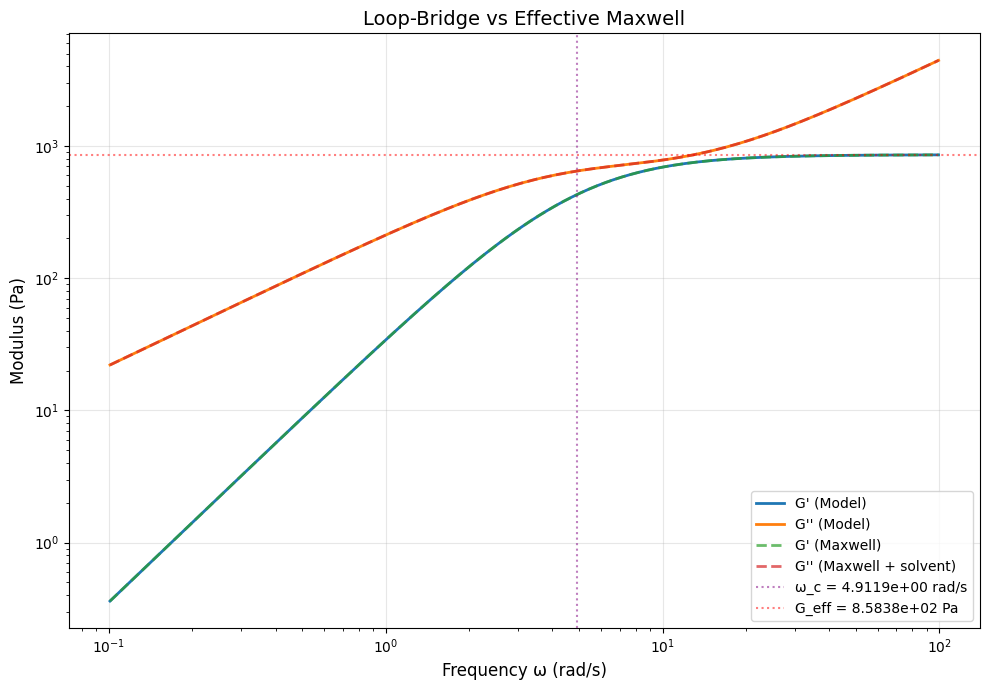


Effective Maxwell parameters:
  G_eff = f_B_eq * G: 8.5838e+02 Pa
  tau_eff = tau_b: 2.0359e-01 s
  Crossover frequency ω_c: 4.9119e+00 rad/s
  Bridge fraction f_B_eq: 0.5490
  Plateau modulus G: 1.5635e+03 Pa


In [5]:
# Compute effective Maxwell parameters
G_eff = model.parameters.get_value('f_B_eq') * model.parameters.get_value('G')
tau_eff = model.parameters.get_value('tau_b')
omega_c = 1.0 / tau_eff

# Maxwell predictions
G_prime_maxwell, G_double_prime_maxwell = compute_maxwell_moduli(omega_pred, G_eff, tau_eff)
G_double_prime_maxwell_with_solvent = G_double_prime_maxwell + model.parameters.get_value('eta_s') * omega_pred

fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(omega_pred, G_prime_pred, '-', label="G' (Model)", linewidth=2)
ax.loglog(omega_pred, G_double_prime_pred, '-', label="G'' (Model)", linewidth=2)
ax.loglog(omega_pred, G_prime_maxwell, '--', label="G' (Maxwell)", linewidth=2, alpha=0.7)
ax.loglog(omega_pred, G_double_prime_maxwell_with_solvent, '--', label="G'' (Maxwell + solvent)", linewidth=2, alpha=0.7)
ax.axvline(omega_c, color='purple', linestyle=':', alpha=0.5, label=f'ω_c = {omega_c:.4e} rad/s')
ax.axhline(G_eff, color='r', linestyle=':', alpha=0.5, label=f'G_eff = {G_eff:.4e} Pa')
ax.set_xlabel('Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.set_title('Loop-Bridge vs Effective Maxwell', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nEffective Maxwell parameters:")
print(f"  G_eff = f_B_eq * G: {G_eff:.4e} Pa")
print(f"  tau_eff = tau_b: {tau_eff:.4e} s")
print(f"  Crossover frequency ω_c: {omega_c:.4e} rad/s")
print(f"  Bridge fraction f_B_eq: {model.parameters.get_value('f_B_eq'):.4f}")
print(f"  Plateau modulus G: {model.parameters.get_value('G'):.4e} Pa")

## Physical Analysis: Crossover Frequency

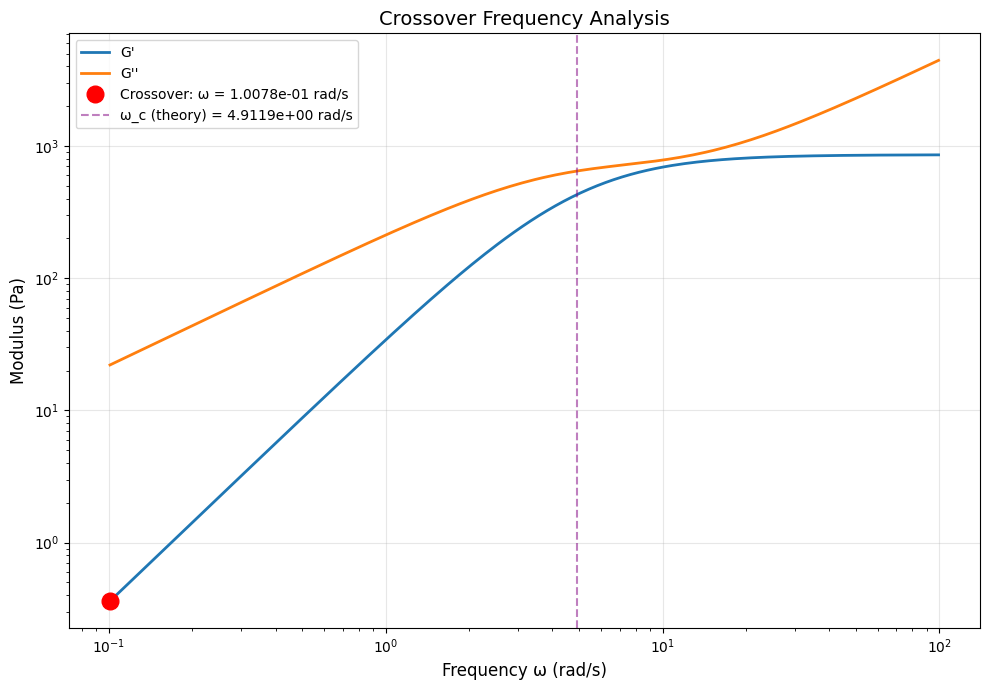


Crossover analysis:
  Measured crossover ω: 1.0078e-01 rad/s
  Theoretical ω_c = 1/tau_b: 4.9119e+00 rad/s
  Ratio (measured/theory): 0.0205
  Modulus at crossover: 3.6123e-01 Pa
  G_eff / 2 (Maxwell prediction): 4.2919e+02 Pa


In [6]:
# Find crossover where G' = G''
diff = jnp.abs(G_prime_pred - G_double_prime_pred)
crossover_idx = jnp.argmin(diff)
omega_crossover = omega_pred[crossover_idx]
G_crossover = G_prime_pred[crossover_idx]

fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(omega_pred, G_prime_pred, '-', label="G'", linewidth=2)
ax.loglog(omega_pred, G_double_prime_pred, '-', label="G''", linewidth=2)
ax.plot(omega_crossover, G_crossover, 'ro', markersize=12, label=f'Crossover: ω = {omega_crossover:.4e} rad/s')
ax.axvline(omega_c, color='purple', linestyle='--', alpha=0.5, label=f'ω_c (theory) = {omega_c:.4e} rad/s')
ax.set_xlabel('Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.set_title('Crossover Frequency Analysis', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nCrossover analysis:")
print(f"  Measured crossover ω: {omega_crossover:.4e} rad/s")
print(f"  Theoretical ω_c = 1/tau_b: {omega_c:.4e} rad/s")
print(f"  Ratio (measured/theory): {omega_crossover / omega_c:.4f}")
print(f"  Modulus at crossover: {G_crossover:.4e} Pa")
print(f"  G_eff / 2 (Maxwell prediction): {G_eff / 2:.4e} Pa")

## Physical Analysis: Frequency Regimes

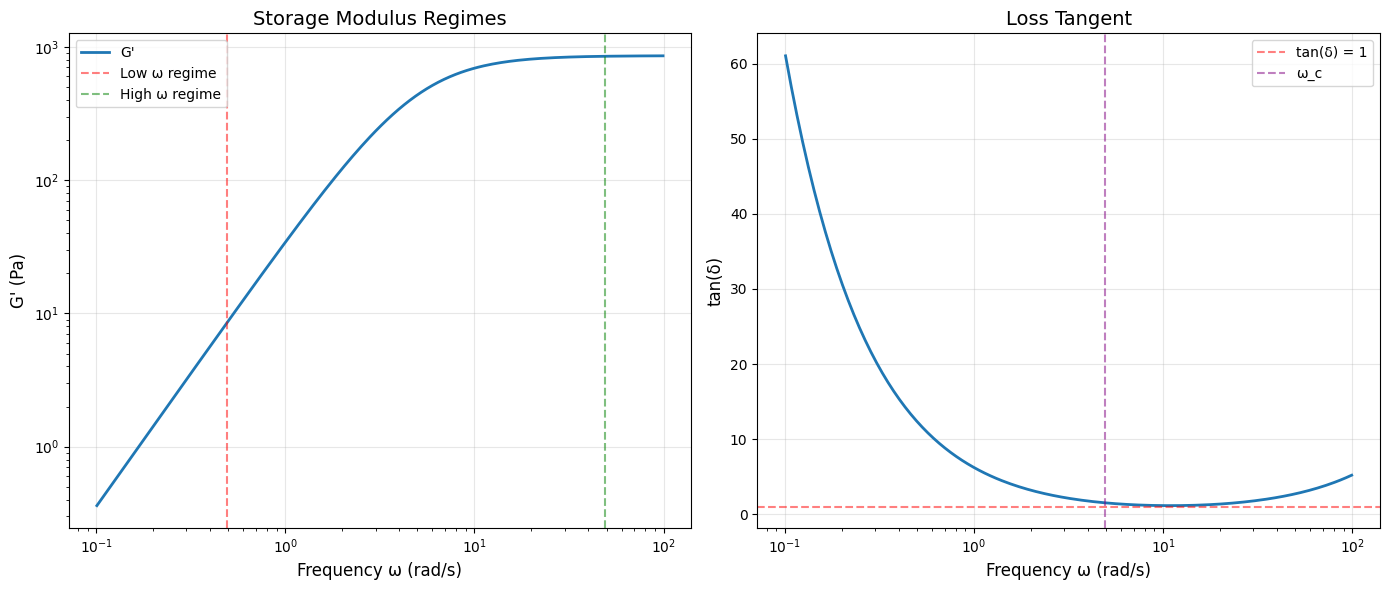


Frequency regime analysis:

1. Low frequency (ω << ω_c):
   ω = 4.9601e-01 rad/s
   G' = 8.6647e+00 Pa
   G'' = 1.0774e+02 Pa
   tan(δ) = 12.4345
   Regime: Liquid-like (G'' > G')

2. High frequency (ω >> ω_c):
   ω = 4.9723e+01 rad/s
   G' = 8.5008e+02 Pa
   G'' = 2.2830e+03 Pa
   tan(δ) = 2.6856
   Regime: Solid-like (G' > G'')
   G' / G_eff = 0.9903


In [7]:
# Define regime boundaries
omega_low = omega_c / 10
omega_high = omega_c * 10

# Extract values in each regime
idx_low = jnp.argmin(jnp.abs(omega_pred - omega_low))
idx_high = jnp.argmin(jnp.abs(omega_pred - omega_high))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# G' vs ω showing regimes
ax1.loglog(omega_pred, G_prime_pred, '-', linewidth=2, label="G'")
ax1.axvline(omega_low, color='r', linestyle='--', alpha=0.5, label='Low ω regime')
ax1.axvline(omega_high, color='g', linestyle='--', alpha=0.5, label='High ω regime')
ax1.set_xlabel('Frequency ω (rad/s)', fontsize=12)
ax1.set_ylabel('G\' (Pa)', fontsize=12)
ax1.set_title('Storage Modulus Regimes', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Loss tangent
tan_delta_pred = G_double_prime_pred / G_prime_pred
ax2.semilogx(omega_pred, tan_delta_pred, '-', linewidth=2)
ax2.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='tan(δ) = 1')
ax2.axvline(omega_c, color='purple', linestyle='--', alpha=0.5, label='ω_c')
ax2.set_xlabel('Frequency ω (rad/s)', fontsize=12)
ax2.set_ylabel('tan(δ)', fontsize=12)
ax2.set_title('Loss Tangent', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nFrequency regime analysis:")
print(f"\n1. Low frequency (ω << ω_c):")
print(f"   ω = {omega_pred[idx_low]:.4e} rad/s")
print(f"   G' = {G_prime_pred[idx_low]:.4e} Pa")
print(f"   G'' = {G_double_prime_pred[idx_low]:.4e} Pa")
print(f"   tan(δ) = {tan_delta_pred[idx_low]:.4f}")
print(f"   Regime: Liquid-like (G'' > G')")

print(f"\n2. High frequency (ω >> ω_c):")
print(f"   ω = {omega_pred[idx_high]:.4e} rad/s")
print(f"   G' = {G_prime_pred[idx_high]:.4e} Pa")
print(f"   G'' = {G_double_prime_pred[idx_high]:.4e} Pa")
print(f"   tan(δ) = {tan_delta_pred[idx_high]:.4f}")
print(f"   Regime: Solid-like (G' > G'')")
print(f"   G' / G_eff = {G_prime_pred[idx_high] / G_eff:.4f}")

## Bayesian Inference

In [8]:
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Starting Bayesian inference with NUTS...")
print(f"  Warmup: {NUM_WARMUP}, Samples: {NUM_SAMPLES}, Chains: {NUM_CHAINS}")

t_start = time.time()
bayes_result = model.fit_bayesian(
    omega, G_star_mag,
    test_mode='oscillation',
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    seed=42
)
t_bayes = time.time() - t_start

print(f"\nBayesian inference completed in {t_bayes:.2f} seconds")
print(f"Speedup vs NLSQ: {t_bayes/t_nlsq:.1f}x slower (includes MCMC overhead)")

Starting Bayesian inference with NUTS...
  Warmup: 200, Samples: 500, Chains: 1


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<04:08,  2.82it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 12/700 [00:00<00:21, 32.10it/s, 1023 steps of size 1.15e-03. acc. prob=0.75]

warmup:   3%|▎         | 18/700 [00:00<00:19, 35.18it/s, 1023 steps of size 1.92e-03. acc. prob=0.83]

warmup:   4%|▎         | 26/700 [00:00<00:15, 43.91it/s, 703 steps of size 4.18e-03. acc. prob=0.88] 

warmup:   5%|▍         | 32/700 [00:00<00:14, 47.47it/s, 1023 steps of size 6.66e-03. acc. prob=0.91]

warmup:   6%|▌         | 39/700 [00:00<00:12, 53.25it/s, 319 steps of size 9.65e-03. acc. prob=0.92] 

warmup:   7%|▋         | 52/700 [00:01<00:08, 74.29it/s, 511 steps of size 1.29e-02. acc. prob=0.94]

warmup:   9%|▉         | 65/700 [00:01<00:07, 89.94it/s, 511 steps of size 1.15e-02. acc. prob=0.94]

warmup:  11%|█▏        | 79/700 [00:01<00:06, 101.71it/s, 511 steps of size 1.01e-02. acc. prob=0.95]

warmup:  13%|█▎        | 90/700 [00:01<00:05, 103.50it/s, 127 steps of size 1.02e-02. acc. prob=0.95]

warmup:  14%|█▍        | 101/700 [00:01<00:05, 101.67it/s, 255 steps of size 7.36e-02. acc. prob=0.95]

warmup:  16%|█▌        | 112/700 [00:01<00:06, 97.47it/s, 1023 steps of size 4.21e-03. acc. prob=0.95]

warmup:  17%|█▋        | 122/700 [00:01<00:06, 88.79it/s, 511 steps of size 6.23e-03. acc. prob=0.95] 

warmup:  19%|█▉        | 136/700 [00:01<00:05, 101.57it/s, 567 steps of size 6.26e-03. acc. prob=0.95]

warmup:  21%|██        | 147/700 [00:01<00:05, 96.90it/s, 255 steps of size 7.81e-03. acc. prob=0.96] 

warmup:  22%|██▏       | 157/700 [00:02<00:06, 85.90it/s, 1023 steps of size 4.14e-03. acc. prob=0.95]

warmup:  24%|██▎       | 166/700 [00:02<00:06, 82.33it/s, 1023 steps of size 5.28e-03. acc. prob=0.96]

warmup:  25%|██▌       | 175/700 [00:02<00:06, 80.70it/s, 1023 steps of size 5.64e-03. acc. prob=0.96]

warmup:  26%|██▋       | 184/700 [00:02<00:06, 79.58it/s, 511 steps of size 6.72e-03. acc. prob=0.96] 

warmup:  28%|██▊       | 195/700 [00:02<00:05, 86.93it/s, 511 steps of size 6.49e-03. acc. prob=0.96]

sample:  29%|██▉       | 204/700 [00:02<00:06, 79.34it/s, 511 steps of size 6.55e-03. acc. prob=0.96]

sample:  31%|███       | 216/700 [00:02<00:05, 89.30it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [00:02<00:05, 85.12it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  34%|███▍      | 237/700 [00:03<00:05, 89.96it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  35%|███▌      | 247/700 [00:03<00:05, 84.52it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 

sample:  37%|███▋      | 256/700 [00:03<00:05, 82.59it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [00:03<00:05, 84.38it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  39%|███▉      | 274/700 [00:03<00:05, 79.78it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  40%|████      | 283/700 [00:03<00:05, 72.23it/s, 279 steps of size 6.55e-03. acc. prob=0.99] 

sample:  42%|████▏     | 294/700 [00:03<00:05, 81.18it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  43%|████▎     | 304/700 [00:03<00:04, 84.49it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [00:04<00:04, 81.56it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  46%|████▌     | 322/700 [00:04<00:05, 72.95it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  47%|████▋     | 332/700 [00:04<00:04, 76.99it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 

sample:  49%|████▉     | 343/700 [00:04<00:04, 84.78it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  50%|█████     | 352/700 [00:04<00:04, 81.88it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  52%|█████▏    | 361/700 [00:04<00:04, 80.31it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  53%|█████▎    | 370/700 [00:04<00:04, 72.40it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  54%|█████▍    | 379/700 [00:04<00:04, 76.35it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  55%|█████▌    | 387/700 [00:04<00:04, 75.90it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 

sample:  57%|█████▋    | 397/700 [00:05<00:03, 79.79it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  59%|█████▊    | 410/700 [00:05<00:03, 90.86it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  60%|██████    | 422/700 [00:05<00:02, 97.09it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 

sample:  62%|██████▏   | 432/700 [00:05<00:02, 96.17it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  63%|██████▎   | 442/700 [00:05<00:02, 94.36it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  65%|██████▍   | 452/700 [00:05<00:03, 80.96it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  66%|██████▌   | 462/700 [00:05<00:02, 84.80it/s, 783 steps of size 6.55e-03. acc. prob=0.99]

sample:  67%|██████▋   | 471/700 [00:05<00:02, 85.42it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  69%|██████▉   | 484/700 [00:06<00:02, 95.93it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  71%|███████   | 496/700 [00:06<00:01, 102.34it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  72%|███████▏  | 507/700 [00:06<00:02, 89.72it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 

sample:  74%|███████▍  | 517/700 [00:06<00:02, 82.15it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  75%|███████▌  | 527/700 [00:06<00:02, 85.61it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  77%|███████▋  | 539/700 [00:06<00:01, 89.43it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  79%|███████▊  | 550/700 [00:06<00:01, 93.59it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 

sample:  80%|████████  | 560/700 [00:06<00:01, 83.77it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  81%|████████▏ | 569/700 [00:07<00:01, 82.23it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 

sample:  83%|████████▎ | 578/700 [00:07<00:01, 77.74it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  84%|████████▎ | 586/700 [00:07<00:01, 76.50it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [00:07<00:01, 86.12it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 

sample:  87%|████████▋ | 607/700 [00:07<00:01, 85.68it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  88%|████████▊ | 616/700 [00:07<00:00, 85.58it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  89%|████████▉ | 625/700 [00:07<00:00, 83.59it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 

sample:  91%|█████████ | 634/700 [00:07<00:00, 77.00it/s, 255 steps of size 6.55e-03. acc. prob=0.99]

sample:  92%|█████████▏| 642/700 [00:07<00:00, 72.05it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  93%|█████████▎| 650/700 [00:08<00:00, 71.44it/s, 511 steps of size 6.55e-03. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [00:08<00:00, 72.29it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  95%|█████████▌| 666/700 [00:08<00:00, 72.89it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample:  96%|█████████▋| 674/700 [00:08<00:00, 73.84it/s, 127 steps of size 6.55e-03. acc. prob=0.99] 

sample:  98%|█████████▊| 683/700 [00:08<00:00, 76.16it/s, 767 steps of size 6.55e-03. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [00:08<00:00, 90.08it/s, 1023 steps of size 6.55e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:08<00:00, 80.83it/s, 511 steps of size 6.55e-03. acc. prob=0.99] 


Bayesian inference completed in 11.21 seconds
Speedup vs NLSQ: 28.7x slower (includes MCMC overhead)


## Convergence Diagnostics

In [9]:
print_convergence_summary(bayes_result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
          tau_b    1.0000       500      PASS
          tau_a    1.0000       500      PASS
             nu    1.0000       500      PASS
         f_B_eq    1.0000       500      PASS
          eta_s    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


True

## Parameter Comparison: NLSQ vs Bayesian

In [10]:
print_parameter_comparison(model, bayes_result.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G          1564     1.776e+04  [2116, 1.578e+05]
          tau_b        0.2036       0.05297  [0.03925, 0.06896]
          tau_a         27.16          4673  [304, 9707]
             nu          7.21         10.15  [0.5867, 19.55]
         f_B_eq         0.549        0.1013  [0.01103, 0.8437]
          eta_s         44.23         30.31  [24.42, 33.68]


## ArviZ: Trace Plot

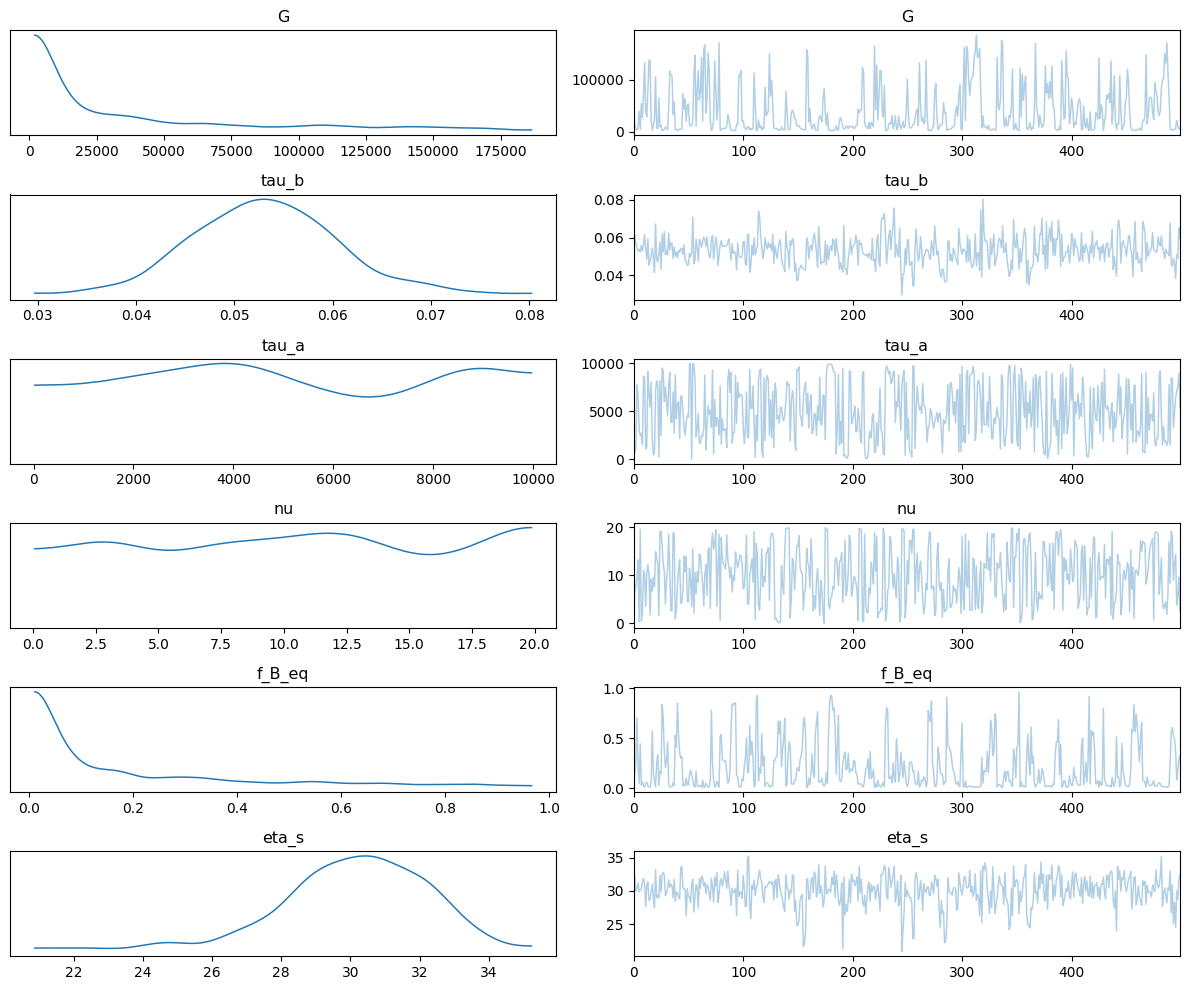

In [11]:
idata = az.from_dict(posterior=bayes_result.posterior_samples)

axes = az.plot_trace(idata, var_names=param_names, compact=False, backend_kwargs={'figsize': (12, 10)})
plt.tight_layout()
plt.show()
plt.close()

## ArviZ: Posterior Distributions

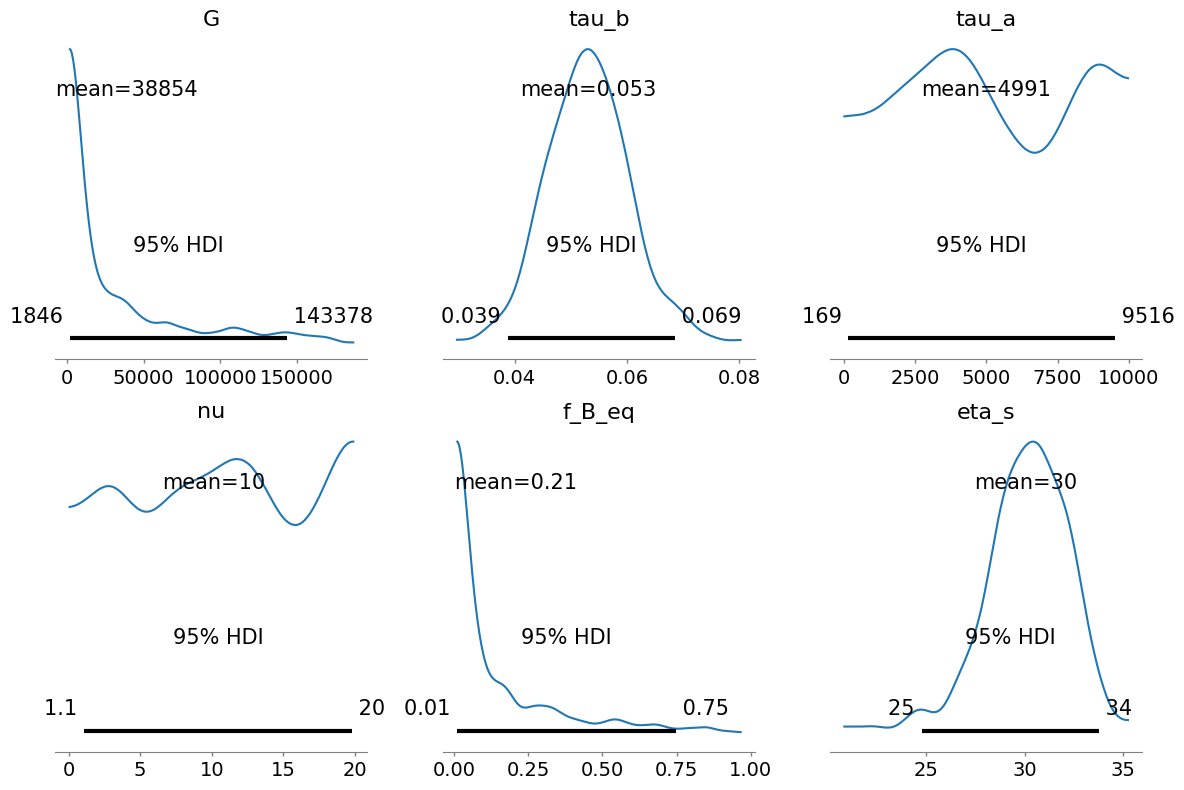

In [12]:
fig = az.plot_posterior(idata, var_names=param_names, hdi_prob=0.95, backend_kwargs={'figsize': (12, 8)})
plt.tight_layout()
plt.show()
plt.close()

## ArviZ: Pair Plot

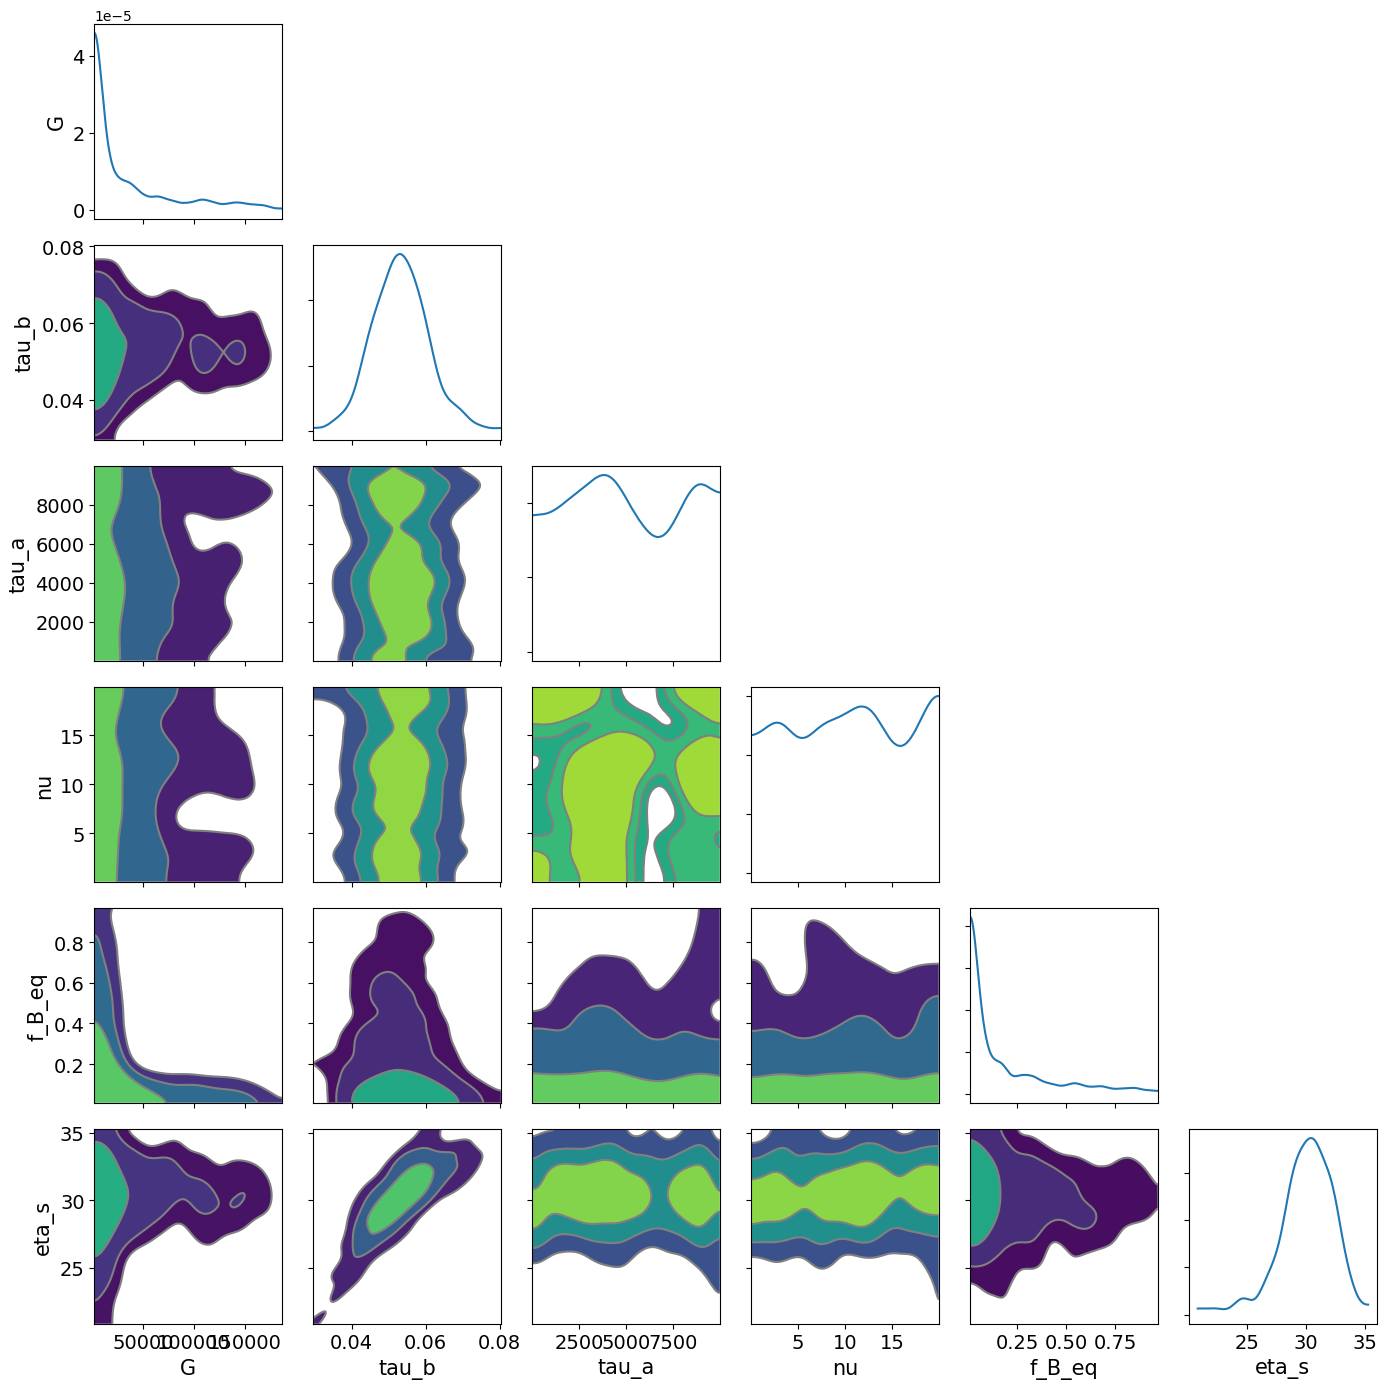

In [13]:
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind='kde',
    marginals=True,
    backend_kwargs={'figsize': (14, 14)}
)
plt.tight_layout()
plt.show()
plt.close()

## Posterior Predictive

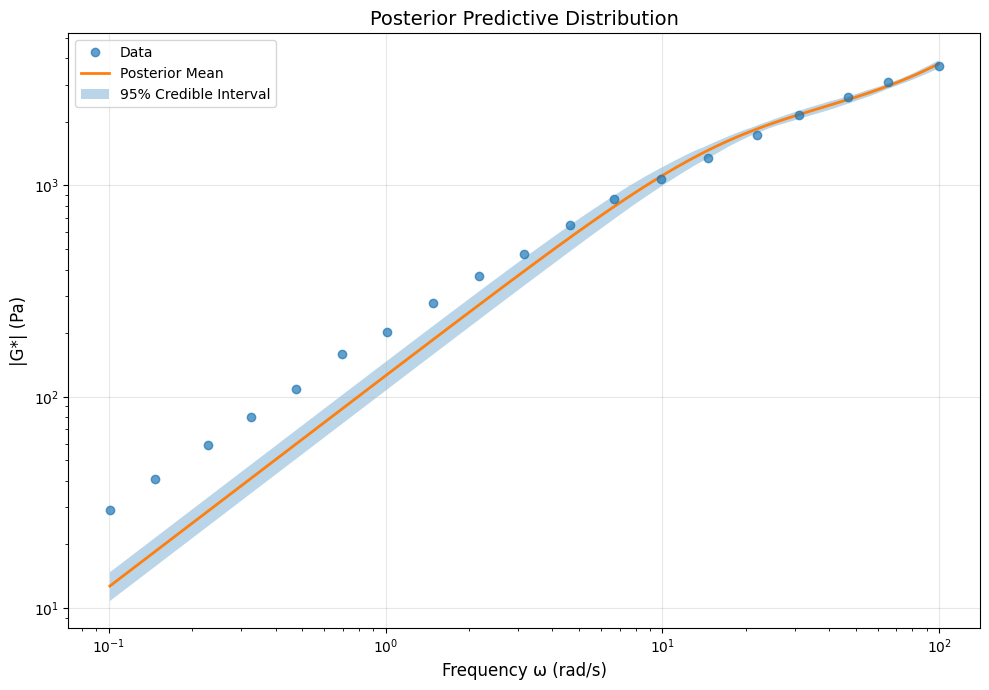

In [14]:
posterior = bayes_result.posterior_samples
n_draws = 200
indices = np.random.choice(NUM_SAMPLES, size=n_draws, replace=False)

predictions = []
for i in indices:
    # Set parameters from posterior sample
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    # Use predict method
    pred = model.predict(omega_pred, test_mode='oscillation')
    predictions.append(np.array(pred))

predictions = np.array(predictions)
pred_mean = predictions.mean(axis=0)
pred_lower = np.percentile(predictions, 2.5, axis=0)
pred_upper = np.percentile(predictions, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(omega, G_star_mag, 'o', label='Data', markersize=6, alpha=0.7, zorder=3)
ax.loglog(omega_pred, pred_mean, '-', label='Posterior Mean', linewidth=2, zorder=2)
ax.fill_between(omega_pred, pred_lower, pred_upper, alpha=0.3, label='95% Credible Interval', zorder=1)
ax.set_xlabel('Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel('|G*| (Pa)', fontsize=12)
ax.set_title('Posterior Predictive Distribution', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close('all')

## Physical Interpretation

In [15]:
print("\n=== Physical Interpretation ===")
print(f"\n1. Material Properties:")
print(f"   - Plateau modulus G: {model.parameters.get_value('G'):.4e} Pa")
print(f"   - Equilibrium bridge fraction: {model.parameters.get_value('f_B_eq'):.4f}")
print(f"   - Effective modulus G_eff: {G_eff:.4e} Pa")
print(f"   - Modulus reduction: {(1 - G_eff/model.parameters.get_value('G'))*100:.2f}%")

print(f"\n2. Maxwell Characteristics:")
print(f"   - Relaxation time tau_b: {model.parameters.get_value('tau_b'):.4e} s")
print(f"   - Crossover frequency ω_c: {omega_c:.4e} rad/s")
print(f"   - Crossover frequency (Hz): {omega_c / (2 * np.pi):.4e} Hz")

print(f"\n3. Frequency Response:")
print(f"   - Low ω: Liquid-like (G'' > G')")
print(f"   - ω ~ ω_c: Crossover (G' = G'')")
print(f"   - High ω: Solid-like (G' > G'')")

print(f"\n4. Solvent Contribution:")
print(f"   - Solvent viscosity η_s: {model.parameters.get_value('eta_s'):.4e} Pa·s")
G_double_prime_high = G_double_prime_pred[idx_high]
solvent_contrib = model.parameters.get_value('eta_s') * omega_pred[idx_high]
print(f"   - G'' at high ω: {G_double_prime_high:.4e} Pa")
print(f"   - Solvent contribution: {solvent_contrib:.4e} Pa ({solvent_contrib/G_double_prime_high*100:.2f}%)")

print(f"\n5. Bridge Kinetics:")
print(f"   - Bridge detachment time tau_b: {model.parameters.get_value('tau_b'):.4e} s")
print(f"   - Loop attachment time tau_a: {model.parameters.get_value('tau_a'):.4e} s")
print(f"   - Ratio tau_a/tau_b: {model.parameters.get_value('tau_a')/model.parameters.get_value('tau_b'):.4f}")
print(f"   - Equilibrium f_B_eq = 1/(1 + tau_a/tau_b): {model.parameters.get_value('f_B_eq'):.4f}")

print(f"\n6. Linear Regime Validity:")
print(f"   - SAOS assumes f_B = f_B_eq (constant)")
print(f"   - Nu parameter: {model.parameters.get_value('nu'):.4f}")
print(f"   - At small strain, Bell detachment negligible")
print(f"   - Model reduces to effective Maxwell")


=== Physical Interpretation ===

1. Material Properties:
   - Plateau modulus G: 4.7636e+04 Pa
   - Equilibrium bridge fraction: 0.0386
   - Effective modulus G_eff: 8.5838e+02 Pa
   - Modulus reduction: 98.20%

2. Maxwell Characteristics:
   - Relaxation time tau_b: 4.3188e-02 s
   - Crossover frequency ω_c: 4.9119e+00 rad/s
   - Crossover frequency (Hz): 7.8175e-01 Hz

3. Frequency Response:
   - Low ω: Liquid-like (G'' > G')
   - ω ~ ω_c: Crossover (G' = G'')
   - High ω: Solid-like (G' > G'')

4. Solvent Contribution:
   - Solvent viscosity η_s: 2.8530e+01 Pa·s
   - G'' at high ω: 2.2830e+03 Pa
   - Solvent contribution: 1.4186e+03 Pa (62.14%)

5. Bridge Kinetics:
   - Bridge detachment time tau_b: 4.3188e-02 s
   - Loop attachment time tau_a: 1.8213e+03 s
   - Ratio tau_a/tau_b: 42170.8215
   - Equilibrium f_B_eq = 1/(1 + tau_a/tau_b): 0.0386

6. Linear Regime Validity:
   - SAOS assumes f_B = f_B_eq (constant)
   - Nu parameter: 0.8731
   - At small strain, Bell detachment negli

## Save Results

In [16]:
save_tnt_results(model, bayes_result, "loop_bridge", "saos", param_names)
print("Results saved to reference_outputs/tnt/loop_bridge_saos_results.npz")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/loop_bridge/saos/
  nlsq_params_saos.json: 6 parameters
  posterior_saos.json: 500 draws
Results saved to reference_outputs/tnt/loop_bridge_saos_results.npz


## Key Takeaways

1. **Linear Response**: SAOS probes equilibrium state where f_B = f_B_eq (constant)

2. **Effective Maxwell**: Model reduces to Maxwell element with G_eff = f_B_eq * G, tau_eff = tau_b

3. **Bridge Fraction**: Determines plateau modulus height (lower f_B_eq → lower G_eff)

4. **Crossover Frequency**: ω_c = 1/tau_b defines transition from liquid-like to solid-like

5. **Solvent Viscosity**: Contributes to G'' at high frequencies, linear in ω

6. **Kinetic Balance**: tau_a/tau_b ratio controls f_B_eq via equilibrium condition

7. **No Bell Physics**: At small strain, force-enhanced detachment is negligible (nu irrelevant)